# Prediction notebook  Workshop Model
## StarDist course, Feb 2024

In [1]:
### Inputs
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois, gputools_available
from stardist.models import StarDist2D
from stardist import export_imagej_rois

from pathlib import Path

np.random.seed(6)
lbl_cmap = random_label_cmap()

/tmp/slurm_64206910/ipykernel_256713/2664070973.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2024-01-30 17:14:52.327284: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Check to see if GPU is enabled
gputools_available()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


True

# Data

## This is our data that we want to segment using our newly trained models
* Enter the path to the data below
* Then run the cell to show the file names, to make sure you got it right

In [3]:
path_to_data = "/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Full_Size_Unseen/"


X = sorted(glob(path_to_data+'/*.tif'))

file_list = []
for name in X:
    file_list.append(os.path.basename(name))
    


X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [4]:
## Show the filenames
file_list

['Image_Set_1_001.tif',
 'Image_Set_2_005.tif',
 'Image_Set_3_015.tif',
 'Image_set_4_014.tif']

In [5]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

Change the model name here.  If it's been saved somewhere else than basedir, change basedir

In [8]:
model_dir = '/nemo/stp/lm/working/fallest/StarDist_Course_Jan_2024/notebooks_checked/models'
if not os.path.exists(model_dir):  #make the directory if it doesn't exist
    os.makedirs(model_dir)

In [9]:
model = StarDist2D(None, name='Crick_test', basedir=model_dir)


2024-01-30 17:16:04.233187: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-01-30 17:16:04.251774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1d:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-01-30 17:16:04.251820: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-01-30 17:16:04.286181: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-01-30 17:16:04.286276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-01-30 17:16:04.332452: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.601403, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

## If you have large data giving errors for out of memory, we change the number of tiles below

##### If you get an Out of memory (OOM) error when using the "Automatic_number_of_tiles" set to true, change it  to false and manually input the values to be used to process your images.  Progressively increases these numbers until the OOM error disappear.

In [10]:
Automatic_number_of_tiles = True 

n_tiles_Y =  12
n_tiles_X =  12

if (Automatic_number_of_tiles): 
  n_tilesYX = None

if not (Automatic_number_of_tiles):
  n_tilesYX = (n_tiles_Y, n_tiles_X)

In [11]:
img = normalize(X[1], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, n_tilesYX)

2024-01-30 17:16:17.042239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-01-30 17:16:17.042882: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2024-01-30 17:16:17.235864: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-01-30 17:16:18.028724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2024-01-30 17:16:19.476507: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-01-30 17:16:19.477472: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


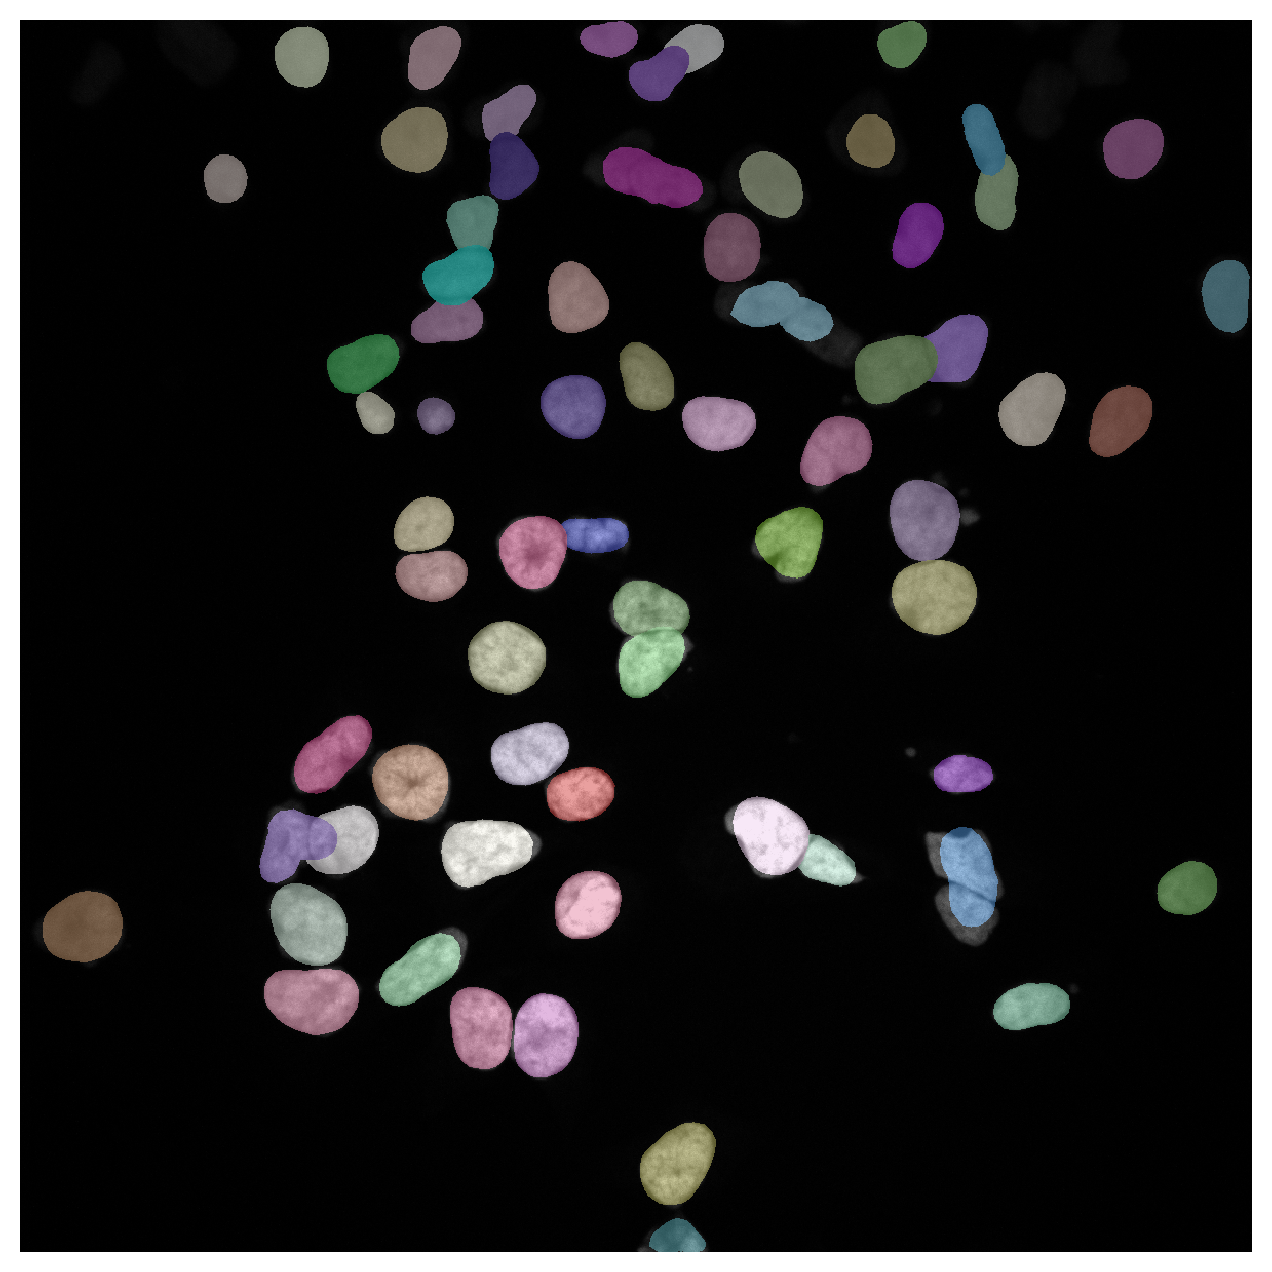

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [13]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

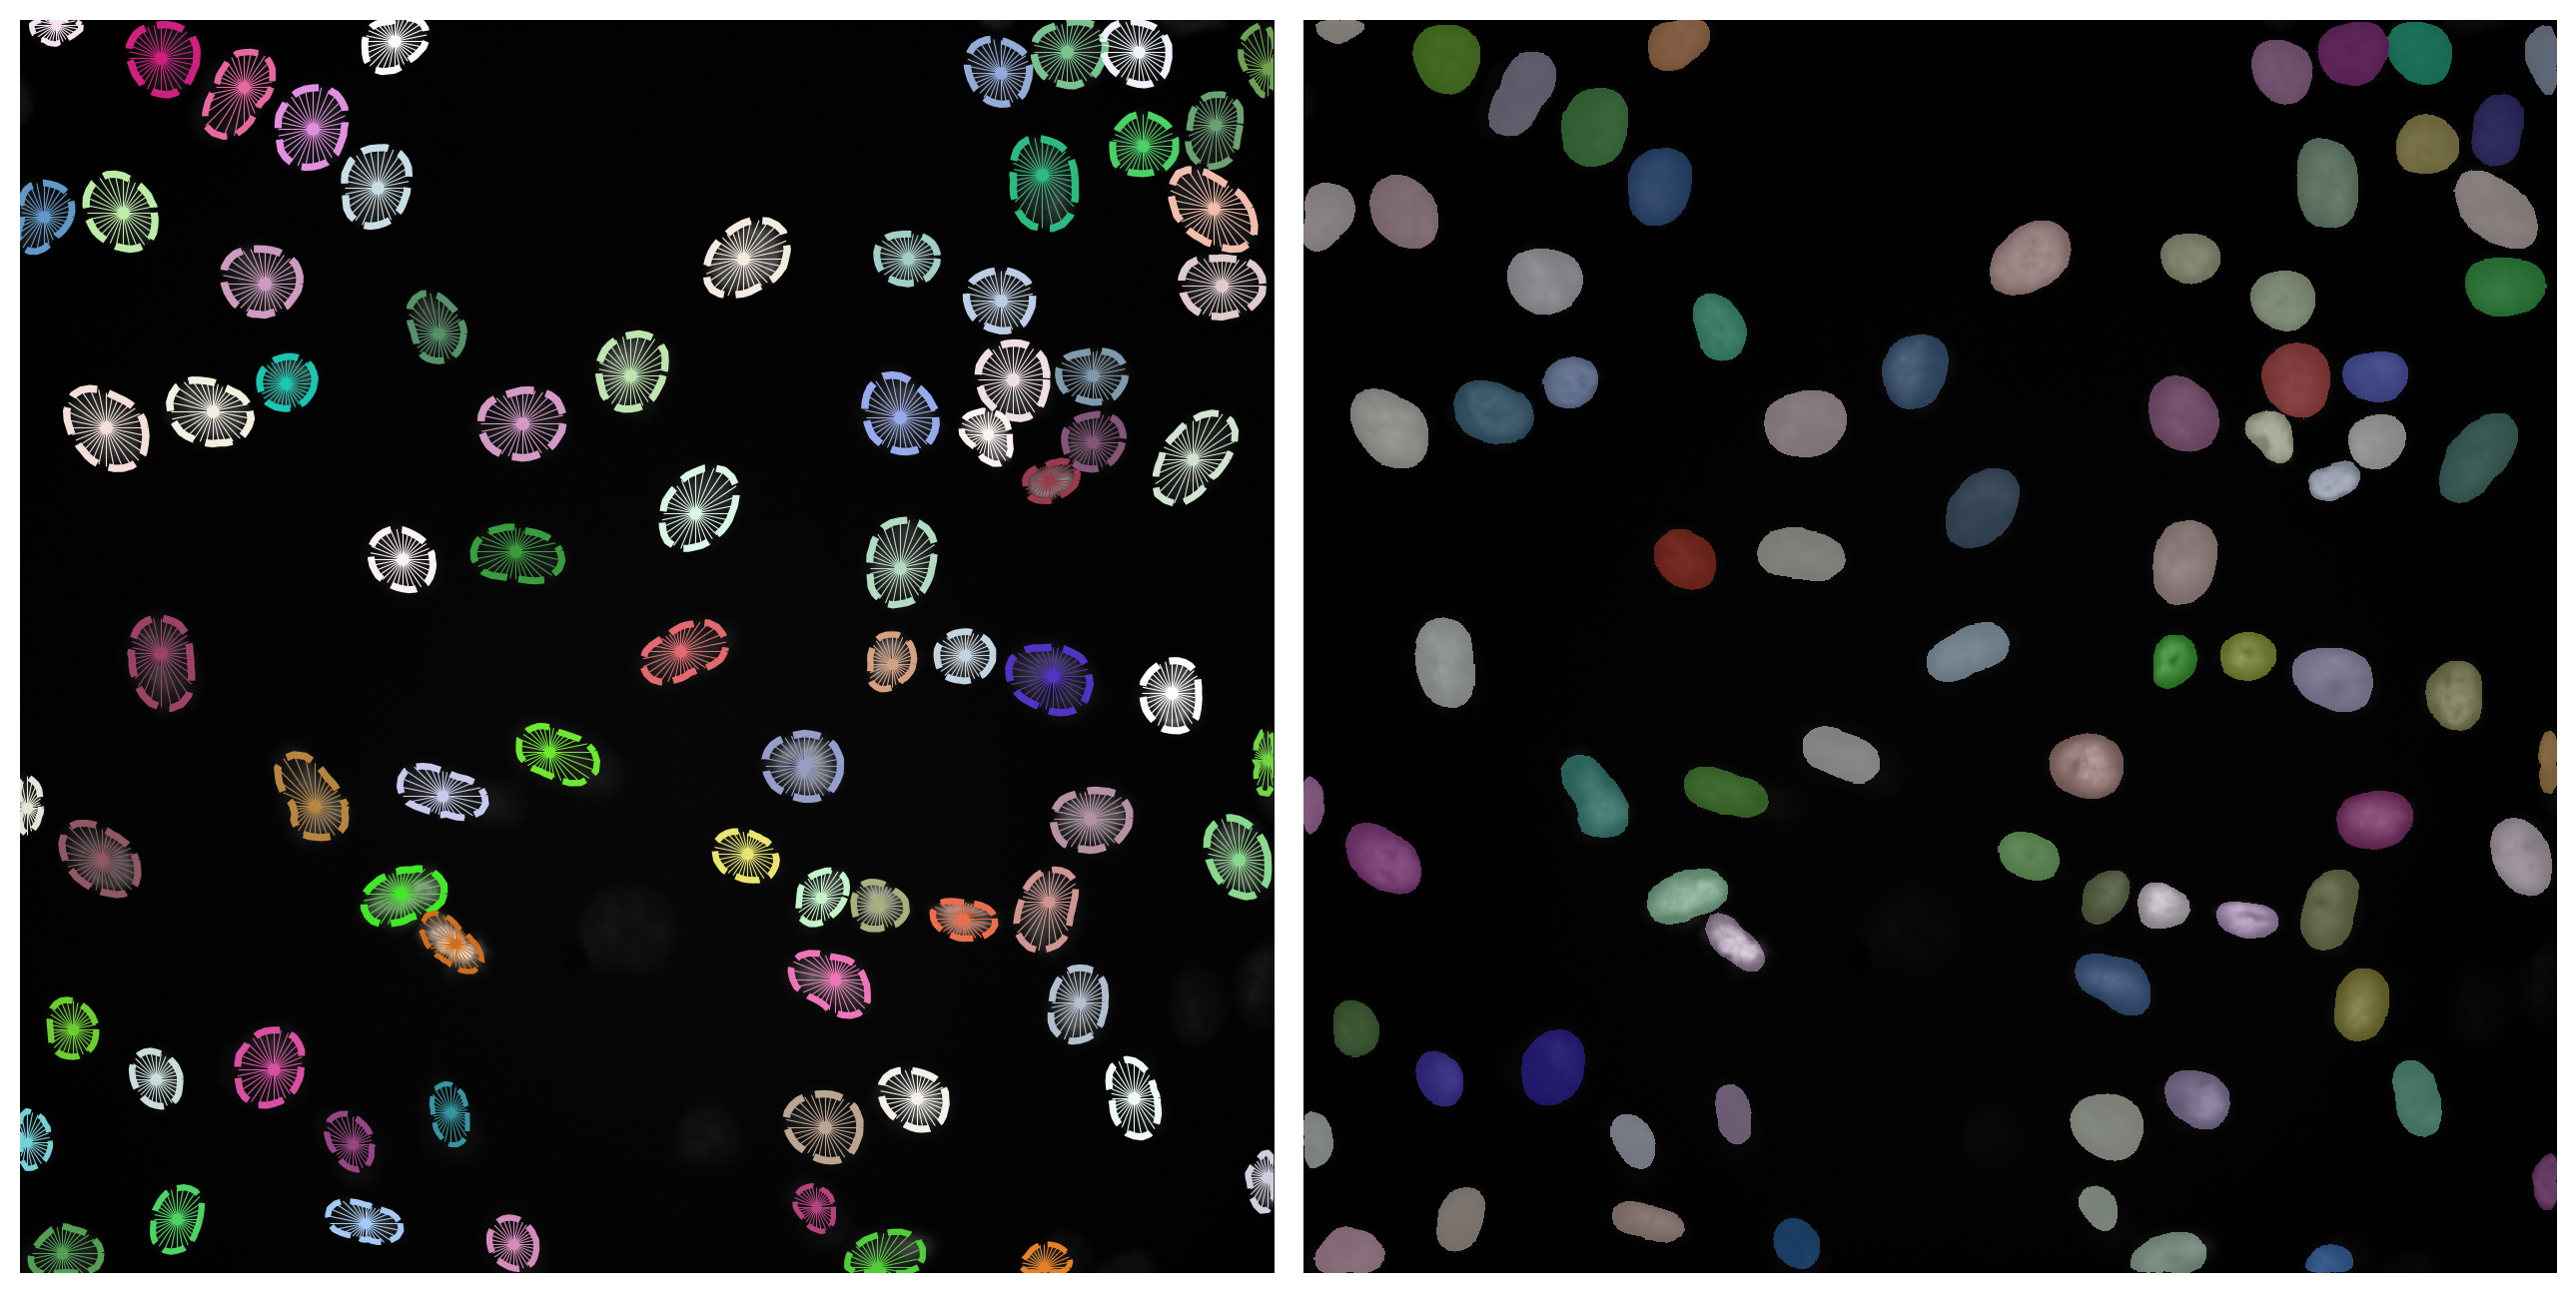

In [14]:
example(model, 2)

In [15]:
## Loop over all images in folder and save the images and predictions

In [16]:
save_directory = '/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Full_Size_Unseen/results/'

Path(save_directory).mkdir(parents=True, exist_ok=True)

for i in range(0,len(X)):
    print(save_directory+file_list[i][:-4]+'_image.tif')
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    #labels, details = model.predict_instances(img)
    labels, polygons = model.predict_instances(img, n_tiles=n_tilesYX)
    save_tiff_imagej_compatible(save_directory+file_list[i][:-4]+'_image.tif', img, axes='YX')
    save_tiff_imagej_compatible(save_directory+file_list[i][:-4]+'_labels.tif', labels, axes='YX')
    #export_imagej_rois(save_directory+file_list[i][:-4]+'img_rois.zip', polygons['coord']) #this line exports the ImageJ rois

/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Full_Size_Unseen/results/Image_Set_1_001_image.tif


__init__.py (43): Converting data type from 'int32' to ImageJ-compatible 'int16'.


/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Full_Size_Unseen/results/Image_Set_2_005_image.tif
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Full_Size_Unseen/results/Image_Set_3_015_image.tif
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Full_Size_Unseen/results/Image_set_4_014_image.tif
